In [172]:
import math
import matplotlib.pyplot as plt
# calculus
import sympy as sym
import random
import numpy as np
import time

In [173]:
def gamma_function(z):
    t = sym.symbols('t')
    integral = (t ** (z-1)) * sym.exp(-t)
    lower_bound = 0
    upper_bound = float('inf')
    result = sym.integrate(integral, (t, lower_bound, upper_bound))
    return result

In [176]:
start_time = time.time()

# Execute the function
result = gamma_function(5)

# Record the end time
end_time = time.time()

print(end_time - start_time)

0.005582094192504883


## Capture probability function

In [161]:
def P_cap(Px, Py, CR, gamma):
    # calculate power ratio threshold
    Pr = 10 ** (CR / 10)
    
    slope_1 = (Py * Pr / Px) ** (1 / gamma)
    slope_2 = (Py / (Px * Pr)) ** (1 / gamma)

    if slope_1 > 1 and slope_2 < 1:
        result = (1 / ((Pr * Py / Px) ** (1 / gamma)) / 2) + (((Py / (Pr * Px)) ** (1 / gamma)) / 2)
    elif slope_1 > 1 and slope_2 >= 1:
        result = 1 - (1 / ((Py / (Pr * Px)) ** (1 / gamma)) - 1 / ((Pr * Py / Px) ** (1 / gamma)) ) / 2
    elif slope_1 <= 1 and slope_2 < 1:
        result = 1 - (((Pr * Py / Px) ** (1 / gamma)) - ((Py / (Pr * Px)) ** (1 / gamma)) ) / 2
    return result

## Gereral analytical

In [162]:

# Lmax: Retransmit limit
# TXOP: in ms
# Imax: total slots in worst case
def analytical(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw_n [ocw_min, 1st_retry_ocw....]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
        
    Ri = [RA_RU for _ in range(0,Imax+1)]
    M  = [0 for _ in range(0,Imax+1)]
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_s_C = [0 for _ in range(0,Imax+1)] # total success packet
    
    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0

                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            
            M[i] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1,Lmax+1) : # n=1;n<=Lmax;n++){
            M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i])
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]
            
#             counter_power += M_i_s[i][n] * 1 * n
            counter_power += M_i[i][n] * 1


        #/** performance metric */  
        #/** success probability */
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    success_probability = success_packet / sta_amount
    access_delay = (TXOP * counter_delay_slot) / success_packet
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    counter_power = counter_power / success_packet
#     counter_power = counter_power / sta_amount
    
    
    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

## Random analytical

In [163]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical_random(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, step, gamma):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    
    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1, Lmax+1):
#             Calculate capture probability
            capture_prob = 0
            if M[i] <= 0:
                M_i_s[i][n] = 0
                M_i_f[i][n] = 0
            else:
                for n1 in range(1, step+1):
                    for n2 in range(1, step+1):
                        # sta_ratio is M_i[n] / M_i
                        sta_ratio_1 = 1 / step
                        sta_ratio_2 = 1 / step
                        # P is the power of two station
                        P1 = 2 ** (n1 - 1)
                        P2 = 2 ** (n2 - 1)
                        capture_prob += P_cap(P1, P2, CR, gamma) * sta_ratio_1 * sta_ratio_2

                M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i]) + capture_prob * M_i[i][n] * (M[i]) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i])
#                 M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i]) + capture_prob * M_i[i][n] * (M[i]-1) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i])
                M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
                M_i_s_C[i] += M_i_s[i][n]
                
                avg_power = sum([2**n for n in range(step)]) / step
#                 counter_power += M_i_s[i][n] * avg_power * (n-1)
#                 # success STA have differnet power usage between captured and no-capture
#                 # capture power (avg power for captured power is 4.25)
#                 counter_power += 4.25 * capture_prob * M_i[i][n] * (M[i]-1) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i])
#                 # no-capture power
#                 counter_power += avg_power * M_i[i][n] * math.exp(-M[i] / Ri[i])
                
                counter_power += avg_power * M_i[i][n]

        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    if success_packet != 0:
        access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # Average power usage
    if success_packet != 0:
        counter_power = counter_power / success_packet
#     counter_power = counter_power / sta_amount
    
    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

## Transmit-based analytical

In [164]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical_rampup(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, step, gamma):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    # set power for its n-th transmission
    power_n = [2 ** (x if x <= (step - 1) else (step - 1)) for x in range(Lmax)]

    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            

        #/** statistics */  
        for n in range (1, Lmax+1):
            #/** Calculate capture probability for slot i */
            capture_prob = 0
            
            if M[i] > 0:
                for s in range(1, step+1):
                    # sta_ratio is M_i[n] / M_i
                    sta_ratio = 0
                    if (s == step):
                        for k in range(s, Lmax+1):
                            sta_ratio += M_i[i][k] / M[i]
                    else:
                        sta_ratio = M_i[i][s] / M[i]

                    # P is the power of two station
                    # calculate power by n-th transmission
                    P1 = 2 ** ((n-1) if (n-1) <= (step - 1) else (step - 1))
                    # calculate power by s-th step
                    P2 = 2 ** (s - 1)

                    capture_prob += P_cap(P1, P2, CR, gamma) * sta_ratio
            M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i]) + capture_prob * M_i[i][n] * (M[i]) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i])
#             M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i]) + capture_prob * M_i[i][n] * (M[i]-1) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i])
                
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]

#             counter_power += M_i_s[i][n] * (sum(power_n[:n]))
            counter_power += M_i[i][n] * power_n[n-1 if n <= step else step]

        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
    
    if success_packet != 0:
        access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # Average power usage
    if success_packet != 0:
        counter_power = counter_power / success_packet
#     counter_power = counter_power / sta_amount

    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

# Scenario I
Scenario III was designed to investigate the impact of transmit power levels $N$ on access success probability.

- Figure: $P_s$ for [$N=1$, $N=2$, $N=3$]
- Parameters: $R=128, C=3dB, L_{max}=5, OCW_{min}=7, OCW_{max}=31$
- x-axis: M STAs (10-200)

In [165]:
R = [9,18,37,74,148]
Lmax = 5
ocw_min = 7
ocw_max = 31
CR = 3
N = 4
T_slot = 5.673

# sta_max = 200

sta_max = 1000
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_ramp  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

# General
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max)
        ps_list[idx][sta-1] = Ps
        da_list[idx][sta-1] = Da
        u_list[idx][sta-1] = U
        power_list[idx][sta-1] = power

# Random
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_random(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, step=N, gamma=2)
        ps_list_random[idx][sta-1] = Ps
        da_list_random[idx][sta-1] = Da
        u_list_random[idx][sta-1] = U
        power_list_random[idx][sta-1] = power

# RampUp
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_rampup(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, step=N, gamma=2)
        ps_list_ramp[idx][sta-1] = Ps
        da_list_ramp[idx][sta-1] = Da
        u_list_ramp[idx][sta-1] = U
        power_list_ramp[idx][sta-1] = power
        

In [166]:
m_list_simu = np.concatenate([np.arange(1, 11, 1), np.arange(20, 110, 10), np.arange(200, 1100, 100)])

### Genral simu result

In [167]:
ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99998, 0.9951550000000033, 0.8032966666666674, 0.4294125000000001, 0.20330399999999887, 0.09681833333333335, 0.04672571428571417, 0.023302499999999914, 0.011384444444444412, 0.005897999999999952]
da_list_simu_148 = [5.672999999999856, 5.735402999999855, 5.7599859999998575, 5.777950499999862, 5.8318439999998715, 5.850753999999871, 5.9104555714284315, 5.9396309999998955, 5.962322999999897, 6.033235499999913, 6.362269500000021, 6.740280399999999, 7.069550775000024, 7.4488759200000185, 7.778628500000003, 8.19521580000001, 8.513542012500055, 8.915812866666665, 9.299273062653057, 14.04194140099018, 17.836764838499256, 18.375816964324926, 18.028541577693446, 17.704704584891253, 17.473260247105767, 17.206154234582453, 17.269189892541746, 17.006939963311723]
t_list_simu_148 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 19.999599999999997, 39.80619999999981, 48.19779999999998, 34.35299999999999, 20.33039999999999, 11.618200000000007, 6.541599999999995, 3.7284000000000015, 2.049200000000002, 1.1795999999999975]
u_list_simu_148 = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513243243243023, 0.26896081081080797, 0.32566081081081066, 0.23211486486486468, 0.13736756756756752, 0.07850135135135124, 0.044199999999999996, 0.025191891891891884, 0.013845945945946011, 0.007970270270270292]
power_list_simu_148 = [1.0, 1.011, 1.015333333333333, 1.0185, 1.027999999999999, 1.0313333333333343, 1.0418571428571455, 1.047, 1.0509999999999955, 1.0635000000000048, 1.1215000000000057, 1.1881333333333393, 1.2461750000000027, 1.313040000000002, 1.371166666666665, 1.4446000000000008, 1.5007125000000021, 1.571622222222224, 1.639318163265307, 2.4998915645223327, 4.384967877674983, 9.953864039782061, 23.004565477644185, 50.63815431181972, 108.58008540833075, 225.05152064799915, 492.6347755443622, 1028.6076920940166]

### random simu result

In [168]:
ps_list_simu_148_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9920833333333389, 0.8488050000000006, 0.5304519999999995, 0.2839599999999993, 0.14651571428571422, 0.07678875000000003, 0.04108777777777762, 0.021894999999999887]
da_list_simu_148_random = [5.672999999999856, 5.692855499999857, 5.701364999999859, 5.741075999999866, 5.760364199999872, 5.794969499999862, 5.824550142857021, 5.841062624999896, 5.870924666666556, 5.885737499999916, 6.130811099999996, 6.325584099999995, 6.559264425000021, 6.804196200000015, 7.019108350000004, 7.239801557142855, 7.51856872500004, 7.736270100000015, 7.987073429999986, 10.85517204000003, 14.668211189625842, 17.814578031711697, 18.60980798098876, 18.382607343037566, 17.969375153501716, 17.660231141291614, 17.39656442544879, 17.261933862150578]
t_list_simu_148_random = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 40.0, 59.52500000000011, 67.90440000000002, 53.04519999999993, 34.075199999999974, 20.51220000000003, 12.286199999999996, 7.395799999999995, 4.379000000000001]
u_list_simu_148_random = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.27027027027026584, 0.40219594594594466, 0.45881351351351396, 0.35841351351351386, 0.23023783783783758, 0.13859594594594582, 0.08301486486486469, 0.0499716216216216, 0.02958783783783783]
power_list_simu_148_random = [3.827, 3.759, 3.7690000000000055, 3.71325, 3.7568, 3.861333333333334, 3.8022857142857136, 3.82925, 3.9323333333333315, 3.888899999999996, 4.04575, 4.183700000000001, 4.306825000000001, 4.519779999999998, 4.655200000000003, 4.780471428571425, 4.9465, 5.1333333333333355, 5.256570000000002, 7.164215, 9.84103675889672, 15.145670437092845, 28.984649491526817, 59.77320970725764, 122.28661958727538, 241.13426939683035, 461.11228297505266, 887.331159796317]

### Ramp Up simu result

In [147]:
ps_list_simu_148_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998900000000001, 0.9840400000000091, 0.8056550000000006, 0.49210800000000054, 0.2627683333333335, 0.13752857142857153, 0.07224374999999994, 0.038073333333333265, 0.020216999999999916]
da_list_simu_148_ramp = [5.672999999999856, 5.698528499999858, 5.72216599999986, 5.736821249999864, 5.750152799999865, 5.779841499999864, 5.839137857142733, 5.849572124999893, 5.890464999999888, 5.894246999999905, 6.1356331499999905, 6.350356199999995, 6.595004325000015, 6.856841640000016, 7.086049750000004, 7.338025499999997, 7.588133887500045, 7.843678900000022, 8.109042929999985, 11.13038959817802, 15.039722979251843, 17.840165315538236, 18.475167761157543, 18.22646860448752, 17.85305950550303, 17.632513695372396, 17.38157210928839, 17.333416174880306]
t_list_simu_148_ramp = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 39.99559999999999, 59.04239999999991, 64.45239999999998, 49.21080000000001, 31.532200000000017, 19.25400000000003, 11.559, 6.853200000000003, 4.0434]
u_list_simu_148_ramp = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.2702405405405362, 0.3989351351351338, 0.43548918918918933, 0.33250540540540563, 0.21305540540540516, 0.13009459459459463, 0.0781013513513513, 0.046305405405405356, 0.02732027027027026]
power_list_simu_148_ramp = [1.0, 1.009, 1.0173333333333332, 1.0225, 1.0271999999999997, 1.0376666666666667, 1.0591428571428583, 1.06325, 1.0771111111111071, 1.0786000000000024, 1.1655000000000038, 1.2428000000000061, 1.3359500000000002, 1.4364000000000001, 1.5297333333333334, 1.6362571428571409, 1.746199999999999, 1.8652444444444454, 1.9923999999999977, 3.9033435536267196, 7.891581574539031, 16.121619990938562, 35.15462367023711, 76.06081206384586, 156.44781673077782, 310.4362797533958, 607.1436157952535, 1182.8354122609978]

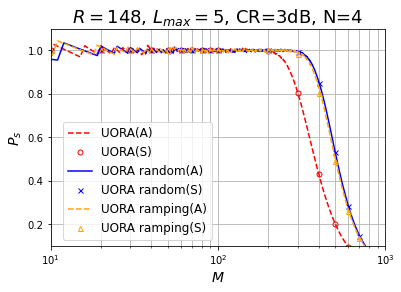

In [148]:
# print(ps_list[4])
# general
plt.semilogx(m_list, ps_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, ps_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, ps_list_random[4], color='blue', label='UORA random(A)')
plt.semilogx(m_list_simu, ps_list_simu_148_random, label='UORA random(S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.semilogx(m_list, ps_list_ramp[4], linestyle = '--', color='orange', label='UORA ramping(A)')
plt.semilogx(m_list_simu, ps_list_simu_148_ramp, label='UORA ramping(S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R=148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$P_s$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.5, 0.3), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

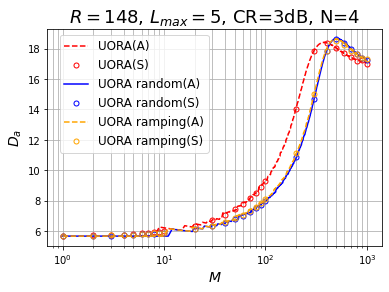

In [149]:
# general
plt.semilogx(m_list, da_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, da_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, da_list_random[4], color='blue', label='UORA random(A)')
plt.semilogx(m_list_simu, da_list_simu_148_random, label='UORA random(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.semilogx(m_list, da_list_ramp[4], linestyle = '--', color='orange', label='UORA ramping(A)')
plt.semilogx(m_list_simu, da_list_simu_148_ramp, label='UORA ramping(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$D_a$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.5, 0.7), fontsize = 12)
# plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

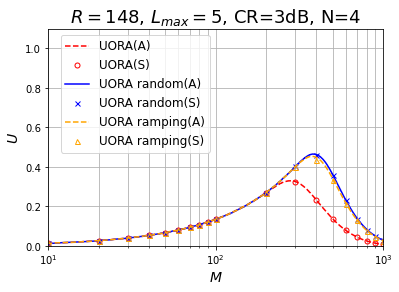

In [150]:
# print(ps_list[4])
# general
plt.semilogx(m_list, u_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, u_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, u_list_random[4], color='blue', label='UORA random(A)')
plt.semilogx(m_list_simu, u_list_simu_148_random, label='UORA random(S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.semilogx(m_list, u_list_ramp[4], linestyle = '--', color='orange', label='UORA ramping(A)')
plt.semilogx(m_list_simu, u_list_simu_148_ramp, label='UORA ramping(S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$U$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.5, 0.7), fontsize = 12)
plt.axis([10,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

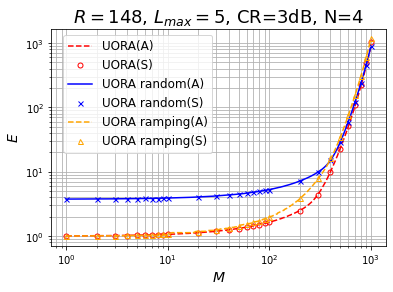

In [151]:
# print(ps_list[4])
# general
plt.plot(m_list, power_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.plot(m_list_simu, power_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.plot(m_list, power_list_random[4], color='blue', label='UORA random(A)')
plt.plot(m_list_simu, power_list_simu_148_random, label='UORA random(S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.plot(m_list, power_list_ramp[4], linestyle = '--', color='orange', label='UORA ramping(A)')
plt.plot(m_list_simu, power_list_simu_148_ramp, label='UORA ramping(S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.yscale('log')
plt.xscale('log')
plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$E$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.5, 0.7), fontsize = 12)
# plt.axis([10,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# Scenario II ($R$ ---> $E$)
Scenario II was designed to investigate the impact of different numbers of RA-RU on power efficiency.

- Figure: $E$ for [$R=9$, $R=18$, $R=37$, $R=74$]
- Parameters: $C=3dB, L_{max}=5, OCW_{min}=7, OCW_{max}=31$, $N=4$
- x-axis: M STAs (10-200)

In [ ]:
R = [9,18,37,74,148]
Lmax = 5
sta_max = 200
# sta_max = 500
m_list = [i for i in range(1, sta_max+1)]

ps_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_ramp  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]


# Random
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_random(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=6, step=4)
        ps_list_random[idx][sta-1] = Ps
        da_list_random[idx][sta-1] = Da
        u_list_random[idx][sta-1] = U
        power_list_random[idx][sta-1] = power

# RampUp
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_rampup(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=6, step=4)
        ps_list_ramp[idx][sta-1] = Ps
        da_list_ramp[idx][sta-1] = Da
        u_list_ramp[idx][sta-1] = U
        power_list_ramp[idx][sta-1] = power

### random simu result

In [ ]:
# Simulation r

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9_random = [1.0, 0.9985000000000003, 0.9739333333333318, 0.8806500000000003, 0.7229999999999995, 0.562016666666667, 0.4301142857142842, 0.3334250000000003, 0.2633222222222221, 0.2148799999999997, 0.17747272727272725, 0.1494916666666668, 0.12896923076923086, 0.113935714285714, 0.09974666666666697, 0.0906249999999999, 0.08232941176470639, 0.07522777777777803, 0.06844736842105258, 0.06428999999999993]
da_list_simu_9_random = [11.43846990000004, 19.03200765175449, 27.427261524746914, 33.97115455373337, 39.092721365786936, 43.1386767442284, 46.45350815197853, 49.554631922306136, 52.407585956812945, 55.010370836070315, 57.080090187862275, 59.14068401166659, 60.96969336262054, 62.48298344481745, 63.764705639671, 64.93030988090963, 65.83113380524621, 66.5885271353087, 67.32920861071733, 67.87887634396074]
t_list_simu_9_random = [0.6666666666666636, 1.331333333333327, 1.9478666666666635, 2.3484000000000065, 2.410000000000002, 2.248066666666668, 2.0071999999999997, 1.7782666666666636, 1.579933333333333, 1.4325333333333339, 1.30146666666667, 1.1959333333333344, 1.1177333333333355, 1.0634000000000026, 0.9974666666666686, 0.9666666666666652, 0.9330666666666663, 0.9027333333333322, 0.8669999999999982, 0.8571999999999991]
u_list_simu_9_random = [0.074074074074075, 0.1479259259259277, 0.2164296296296315, 0.26093333333333385, 0.26777777777777784, 0.24978518518518567, 0.22302222222222212, 0.19758518518518497, 0.17554814814814793, 0.15917037037037024, 0.14460740740740746, 0.13288148148148143, 0.12419259259259274, 0.11815555555555553, 0.11082962962962992, 0.10740740740740738, 0.1036740740740741, 0.10030370370370371, 0.09633333333333324, 0.09524444444444445]
power_list_simu_9_random = [6.2559, 8.898803801169606, 11.485973614584648, 13.378917089045272, 14.67495424044071, 15.589921175327278, 16.249958261560362, 16.827348856532097, 17.156776312447473, 17.54866889003913, 17.89639867242932, 18.053956149132706, 18.217321820445573, 18.34502313221677, 18.548729195003894, 18.61959014744697, 18.747145054925614, 18.83517425652807, 18.828428032927693, 18.755919092208092]


ps_list_simu_18_random = [1.0, 1.0, 0.9986666666666666, 0.9855500000000047, 0.927380000000004, 0.8050333333333336, 0.6566857142857149, 0.5067749999999998, 0.39669999999999933, 0.3091499999999998, 0.24810909090909133, 0.19992500000000024, 0.16466153846153916, 0.13912857142857132, 0.12039333333333378, 0.10278125000000003, 0.09153529411764745, 0.08137222222222242, 0.07293684210526316, 0.06641500000000002]
da_list_simu_18_random = [7.686915000000027, 10.661552550000053, 14.131265440585658, 18.007146615687272, 21.75297157224233, 24.605449264135988, 26.733319319186798, 28.5468898814643, 30.11944969111567, 31.649800749145513, 33.12913044772878, 34.52372729874843, 35.70015711464792, 36.950485215192934, 37.987011745335224, 39.04386941657963, 39.76482418569136, 40.63019731870784, 41.150810942915804, 41.8253222876963]
t_list_simu_18_random = [1.25, 2.5, 3.745, 4.92775, 5.796125, 6.03775, 5.746, 5.06775, 4.462875, 3.864375, 3.4115, 2.998875, 2.67575, 2.43475, 2.257375, 2.055625, 1.945125, 1.830875, 1.73225, 1.660375]
u_list_simu_18_random = [0.06944444444444328, 0.13888888888888656, 0.20805555555555794, 0.2737638888888866, 0.32200694444444494, 0.335430555555556, 0.31922222222222285, 0.2815416666666671, 0.2479375000000003, 0.21468750000000023, 0.18952777777777796, 0.166604166666667, 0.1486527777777775, 0.13526388888888874, 0.12540972222222227, 0.11420138888888902, 0.10806250000000003, 0.10171527777777796, 0.09623611111111108, 0.09224305555555558]
power_list_simu_18_random = [4.988899999999996, 6.679949999999997, 8.540369886881956, 10.398090459212824, 12.208950257846062, 13.495141418847314, 14.404137237417645, 15.209988041908057, 15.698237642621997, 16.15278195778164, 16.68094663145668, 16.97367029851573, 17.35716833008201, 17.686648692950104, 17.97046700835478, 18.195418336847258, 18.325839009547614, 18.35830632878042, 18.577380299888304, 18.615536050392368]


ps_list_simu_37_random = [1.0, 1.0, 1.0, 1.0, 0.99978, 0.9981500000000006, 0.9869142857142832, 0.9495249999999997, 0.8693555555555568, 0.7507900000000004, 0.6165727272727264, 0.4880666666666665, 0.37839230769230675, 0.2889857142857146, 0.22704666666666654, 0.17313749999999997, 0.13443529411764735, 0.10076666666666659, 0.0780263157894736, 0.06056000000000006]
da_list_simu_37_random = [6.637410000000002, 7.714996350000041, 8.838912199999987, 10.07141872500008, 11.54978371147959, 13.06431356623755, 14.809213382614535, 16.329342124953662, 17.44977415030581, 18.08039988773492, 18.404231447411927, 18.498859368491132, 18.41683528576877, 18.305456952550493, 18.151248994175695, 17.95574163396167, 17.935995584667204, 17.670992443051908, 17.594821148125735, 17.490048758649138]
t_list_simu_37_random = [2.0, 4.0, 6.0, 8.0, 9.997800000000002, 11.97780000000001, 13.816800000000006, 15.192399999999996, 15.648399999999995, 15.015800000000004, 13.564599999999986, 11.713600000000014, 9.8382, 8.0916, 6.8114000000000114, 5.540399999999999, 4.5708, 3.6275999999999993, 2.9650000000000007, 2.422399999999998]
u_list_simu_37_random = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.2702108108108064, 0.3237243243243232, 0.3734270270270278, 0.41060540540540624, 0.42292972972972914, 0.4058324324324312, 0.36661081081081043, 0.3165837837837833, 0.26589729729729755, 0.21869189189189162, 0.18409189189189185, 0.14974054054054053, 0.12353513513513502, 0.09804324324324318, 0.08013513513513504, 0.06547027027027057]
power_list_simu_37_random = [4.405600000000003, 5.051950000000002, 5.8604, 6.674699999999998, 7.6518566156462535, 8.653015782522573, 9.783085142504792, 10.84821971074289, 11.640609731909436, 12.142145321158758, 12.453929288694876, 12.547920930174609, 12.565637220692524, 12.524514808391082, 12.500249978151476, 12.390060183204632, 12.370066021550635, 12.261020918054871, 12.207711453395177, 12.120135774078644]


ps_list_simu_74_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999750000000001, 0.9999555555555555, 0.9999, 0.9993636363636367, 0.9979583333333345, 0.9948692307692296, 0.9892857142857093, 0.9735600000000095, 0.9496312499999985, 0.9124764705882322, 0.8698611111111112, 0.8137473684210501, 0.7494550000000002]
da_list_simu_74_random = [6.168820199999948, 6.700096650000014, 7.170861099999994, 7.727193300000044, 8.25580344, 8.887227250000016, 9.517186885714287, 10.124884931730849, 10.833177990909093, 11.539101973469402, 12.359712371842699, 13.147396545273644, 13.976635270899902, 14.792900611103283, 15.644928675109885, 16.35365417989693, 16.94455788747141, 17.425162621150413, 17.81956256373536, 18.115619671852844]
t_list_simu_74_random = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 15.999600000000001, 17.9992, 19.998, 21.98599999999999, 23.950999999999972, 25.866599999999917, 27.699999999999957, 29.206799999999955, 30.38819999999995, 31.02419999999997, 31.314999999999976, 30.922400000000003, 29.97820000000003]
u_list_simu_74_random = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621081081081284, 0.24323243243243808, 0.2702432432432388, 0.29710810810810356, 0.323662162162161, 0.34954864864865137, 0.3743243243243247, 0.39468648648648663, 0.4106513513513517, 0.41924594594594516, 0.4231756756756758, 0.4178702702702697, 0.4051108108108103]
power_list_simu_74_random = [4.067499999999999, 4.453699999999998, 4.7212333333333305, 5.094874999999999, 5.430159999999998, 5.8655500000000025, 6.272542857142855, 6.68540320512821, 7.145338131313135, 7.630599999999998, 8.193777488841913, 8.689034297712668, 9.227885737914248, 9.794447680474418, 10.336694123289254, 10.85651843497912, 11.276942820281906, 11.631061127700093, 11.916939246962507, 12.174554343319892]


ps_list_simu_148_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999777777777777, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999882352941176, 0.9999722222222222, 0.999936842105263, 0.9999250000000001]
da_list_simu_148_random = [5.900487299999912, 6.174209549999991, 6.480078799999998, 6.699103875000028, 6.942050100000006, 7.214637750000001, 7.470125357142863, 7.731731700000039, 8.030642929545472, 8.327623620000006, 8.574172200000001, 8.882310650000012, 9.17223731538462, 9.511189714285717, 9.801544659999983, 10.157861062500059, 10.476158671638633, 10.843429915600609, 11.195024071429177, 11.569368038551842]
t_list_simu_148_random = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 17.999599999999997, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 33.9996, 35.999, 37.9976, 39.99699999999999]
u_list_simu_148_random = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12161891891892176, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2027027027027067, 0.21621621621621823, 0.22972702702703035, 0.24323648648649215, 0.2567405405405346, 0.2702499999999956]
power_list_simu_148_random = [3.8600000000000008, 4.076899999999998, 4.301533333333325, 4.427450000000005, 4.595559999999995, 4.762250000000007, 4.952671428571423, 5.088312500000002, 5.301215656565658, 5.507170000000009, 5.669618181818182, 5.87155833333334, 6.053884615384611, 6.2956357142857104, 6.48323333333333, 6.720875000000002, 6.929920728291321, 7.172076501091512, 7.392801388917793, 7.658367369169075]

### Ramp up simu result (CR=6)

In [17]:
# Simulation r

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9_ramp = [1.0, 0.9976500000000006, 0.966299999999998, 0.8606749999999999, 0.6946800000000013, 0.5363500000000007, 0.4110285714285698, 0.3178250000000001, 0.2497555555555554, 0.20514999999999925, 0.16869090909090922, 0.1441000000000003, 0.12326153846153877, 0.10923571428571409, 0.09600666666666705, 0.08781875000000004, 0.07886470588235353, 0.07216666666666699, 0.06580000000000001, 0.061774999999999934]
da_list_simu_9_ramp = [11.494065300000019, 19.72986627280712, 28.032921313626336, 34.72442163208014, 39.51442405158269, 43.43810233900669, 46.70856281005599, 49.76069908580669, 52.72146119808534, 55.48506835127859, 57.52140839167424, 59.49210816978654, 61.23327015379131, 62.72248794202405, 64.16555975082467, 65.03365821637887, 66.17318737463921, 66.82759445958114, 67.43494452097359, 68.13862499002502]
t_list_simu_9_ramp = [0.6666666666666636, 1.3301999999999943, 1.932599999999996, 2.2951333333333395, 2.315600000000004, 2.1454000000000026, 1.9181333333333344, 1.695066666666664, 1.4985333333333342, 1.3676666666666704, 1.2370666666666703, 1.1528000000000025, 1.0682666666666674, 1.0195333333333336, 0.9600666666666658, 0.9367333333333318, 0.8937999999999977, 0.8659999999999982, 0.833466666666665, 0.823666666666665]
u_list_simu_9_ramp = [0.074074074074075, 0.1478000000000017, 0.21473333333333458, 0.255014814814815, 0.2572888888888894, 0.23837777777777777, 0.21312592592592552, 0.18834074074074061, 0.16650370370370354, 0.15196296296296277, 0.13745185185185196, 0.12808888888888914, 0.1186962962962965, 0.11328148148148157, 0.10667407407407421, 0.10408148148148152, 0.0993111111111112, 0.09622222222222222, 0.09260740740740753, 0.0915185185185186]
power_list_simu_9_ramp = [2.6219999999999994, 5.6192935672514635, 9.403043729564347, 12.577969598187206, 14.679109003100573, 16.21741267691252, 17.344452989677098, 18.29302120793716, 19.218544457211387, 20.0033117472963, 20.4961248749174, 21.017323006959323, 21.41449169305624, 21.718531960552763, 22.007112199453093, 22.177567352006125, 22.39358101874197, 22.470154974105654, 22.57564468431469, 22.670034733309393]


ps_list_simu_18_ramp = [1.0, 1.0, 0.9983333333333335, 0.9788750000000048, 0.9041400000000014, 0.7682666666666673, 0.6137142857142871, 0.4788749999999996, 0.3750222222222217, 0.2924399999999997, 0.23224545454545462, 0.19205833333333325, 0.15574615384615473, 0.1329714285714286, 0.11336666666666703, 0.09800624999999985, 0.08704117647058862, 0.07665000000000025, 0.06972105263157893, 0.06387999999999992]
da_list_simu_18_ramp = [7.879229700000037, 10.81046880000005, 14.71550324247401, 18.592715257621812, 22.194837715246507, 24.879977594841673, 26.988203156523003, 28.80864419400601, 30.372984123395312, 31.858532962389322, 33.38292227180211, 34.58116031461436, 36.016628388162765, 37.131267760220815, 38.22647069415085, 39.20671622285835, 40.02796131532215, 40.73104401453562, 41.30351582307359, 41.87141412426408]
t_list_simu_18_ramp = [1.25, 2.5, 3.74375, 4.894375, 5.650875, 5.762, 5.37, 4.78875, 4.219, 3.6555, 3.193375, 2.880875, 2.530875, 2.327, 2.125625, 1.960125, 1.849625, 1.724625, 1.655875, 1.597]
u_list_simu_18_ramp = [0.06944444444444328, 0.13888888888888656, 0.2079861111111134, 0.2719097222222203, 0.3139375000000006, 0.3201111111111107, 0.29833333333333373, 0.26604166666666673, 0.23438888888888915, 0.20308333333333342, 0.17740972222222212, 0.16004861111111113, 0.1406041666666665, 0.12927777777777794, 0.11809027777777807, 0.10889583333333346, 0.10275694444444448, 0.0958125, 0.09199305555555551, 0.08872222222222195]
power_list_simu_18_ramp = [1.8363999999999983, 3.2153, 5.512121145776316, 8.280582653310208, 10.995197951445391, 12.96839780337792, 14.456801461712484, 15.614057089171364, 16.571020311672406, 17.427184686325422, 18.227078306135592, 18.86833654723926, 19.644028359446157, 20.1884467244409, 20.694650402581164, 21.17209134909541, 21.49152470002253, 21.806763255433356, 22.02682274996918, 22.24498245304636]


ps_list_simu_37_ramp = [1.0, 1.0, 1.0, 0.9997999999999999, 0.9993200000000002, 0.9949166666666674, 0.9742428571428561, 0.9182125000000013, 0.8232888888888895, 0.6966000000000007, 0.5620909090909092, 0.44609166666666633, 0.3443461538461553, 0.2674, 0.2057666666666667, 0.15691875000000005, 0.12032352941176512, 0.09298888888888894, 0.0709631578947368, 0.05550499999999991]
da_list_simu_37_ramp = [6.640813800000002, 7.819379550000042, 9.027634000000011, 10.323471607894799, 11.773824567500002, 13.578760944756878, 15.203911124880355, 16.60235714267966, 17.5531105538535, 18.04724387535872, 18.262307990235016, 18.31965399607261, 18.270890708531468, 18.154188476910797, 18.012622014174802, 17.87963661868377, 17.800331533320968, 17.688059818177795, 17.526244819915647, 17.464145569500737]
t_list_simu_37_ramp = [2.0, 4.0, 6.0, 7.998399999999999, 9.993200000000005, 11.93900000000002, 13.639400000000025, 14.691400000000021, 14.819200000000002, 13.932000000000006, 12.365999999999984, 10.7062, 8.95299999999999, 7.487199999999996, 6.173000000000003, 5.021400000000002, 4.090999999999998, 3.3476000000000012, 2.6965999999999957, 2.2202000000000015]
u_list_simu_37_ramp = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21617297297297497, 0.27008648648648215, 0.3226756756756747, 0.36863243243243266, 0.3970648648648646, 0.40051891891891844, 0.3765405405405398, 0.33421621621621606, 0.28935675675675665, 0.24197297297297285, 0.20235675675675663, 0.16683783783783795, 0.1357135135135136, 0.11056756756756739, 0.09047567567567548, 0.07288108108108117, 0.06000540540540577]
power_list_simu_37_ramp = [1.356200000000006, 1.8598000000000012, 2.4942666666666673, 3.3265973684210572, 4.446063333333337, 6.090020774454277, 7.725692951717012, 9.192862468641017, 10.238313128889917, 10.788133002080269, 11.027263129361263, 11.10580642922579, 11.067899439651159, 10.944667359629744, 10.808308282130305, 10.669011119475236, 10.56632426576491, 10.470103450387835, 10.31500708615371, 10.258795685460044]


ps_list_simu_74_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999714285714285, 0.9999750000000001, 0.9999333333333332, 0.9996200000000003, 0.9984454545454555, 0.9958083333333354, 0.9884769230769208, 0.975464285714283, 0.95345333333334, 0.9212687500000005, 0.8752411764705857, 0.8248666666666686, 0.7597894736842096, 0.694410000000001]
da_list_simu_74_ramp = [6.16882019999995, 6.687048750000013, 7.300772799999991, 7.839235050000047, 8.429851079999999, 9.024513850000014, 9.671523472689065, 10.4030492134616, 11.081973422727275, 11.900776025114416, 12.723834987206216, 13.578892547098512, 14.437286724698247, 15.267573914976344, 16.010850628427832, 16.60227393488331, 17.11166203752559, 17.5197082614724, 17.860282004640418, 18.03993998990313]
t_list_simu_74_ramp = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 13.999600000000001, 15.999600000000001, 17.998800000000003, 19.9924, 21.965799999999987, 23.899399999999968, 25.70039999999993, 27.312999999999953, 28.603599999999947, 29.480600000000017, 29.75819999999999, 29.695199999999996, 28.872000000000007, 27.77639999999999]
u_list_simu_74_ramp = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891837837837858, 0.2162108108108128, 0.2432270270270327, 0.27016756756756327, 0.29683513513513055, 0.32296486486486414, 0.34730270270270475, 0.36909459459459326, 0.38653513513513466, 0.3983864864864858, 0.40213783783783735, 0.40128648648648624, 0.39016216216216143, 0.3753567567567565]
power_list_simu_74_ramp = [1.177000000000003, 1.3742000000000005, 1.6205999999999994, 1.8617500000000005, 2.1586399999999992, 2.4828333333333314, 2.878711764705883, 3.3740794871794897, 3.88538333333333, 4.554224741290456, 5.274683882389382, 6.0840280236561295, 6.935158449047179, 7.780062263606611, 8.560646726999336, 9.192281265955184, 9.756800186491487, 10.195402835545513, 10.5751333881423, 10.776706765351415]


ps_list_simu_148_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999866666666667, 0.999975, 0.9999941176470588, 0.9999333333333336, 0.9998684210526317, 0.9996550000000002]
da_list_simu_148_ramp = [5.903891099999907, 6.216189749999987, 6.475540399999992, 6.755975700000016, 7.0101261000000115, 7.276095249999991, 7.561703785714301, 7.840511475000039, 8.149642700000022, 8.426901119999993, 8.73064385454546, 9.051980625000006, 9.365773892307697, 9.70646247857142, 10.02576615189189, 10.410339632990535, 10.742960889836398, 11.112170413483131, 11.52030142515507, 11.90915163062815]
t_list_simu_148_ramp = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 29.999599999999997, 31.9992, 33.9998, 35.9976, 37.99499999999998, 39.986199999999975]
u_list_simu_148_ramp = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.202700000000004, 0.2162108108108128, 0.2297283783783817, 0.24322702702703264, 0.25672297297296703, 0.2701770270270227]
power_list_simu_148_ramp = [1.0822000000000012, 1.1931000000000032, 1.29053333333334, 1.3960500000000011, 1.5008400000000022, 1.610533333333334, 1.7339999999999995, 1.861349999999998, 2.0135777777777784, 2.1526799999999997, 2.317963636363639, 2.501250000000004, 2.684630769230769, 2.8993714285714307, 3.1117803603603567, 3.3788088607594995, 3.612220048729549, 3.9011431960049925, 4.227942258662746, 4.559207986904223]

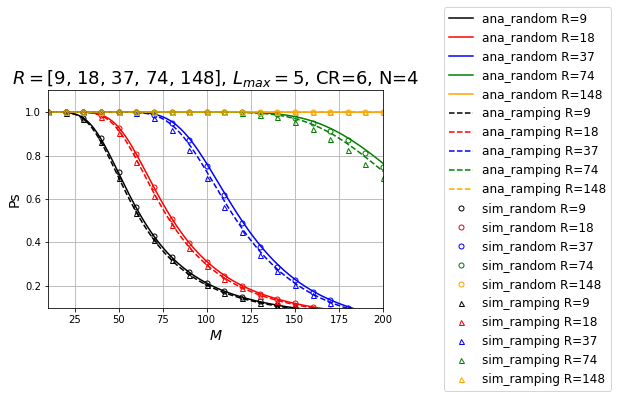

In [18]:
plt.plot(m_list, ps_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, ps_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, ps_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, ps_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, ps_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, ps_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, ps_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, ps_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, ps_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, ps_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, ps_list_simu_9_random, label='sim_random R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.plot(m_list_simu, ps_list_simu_9_ramp, label='sim_ramping R=9', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max}=$' + str(Lmax) + ', CR=6, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

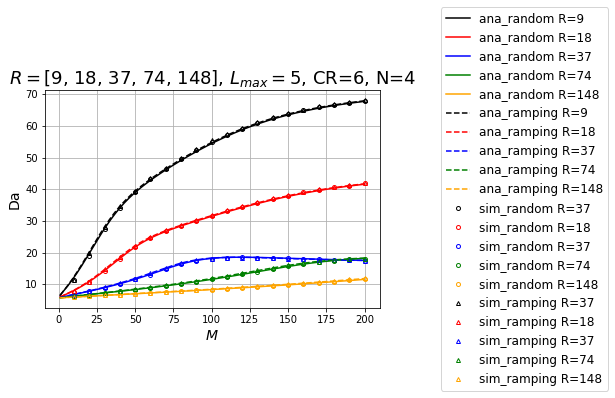

In [19]:
plt.plot(m_list, da_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, da_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, da_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, da_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, da_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, da_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, da_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, da_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, da_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, da_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, da_list_simu_9_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.plot(m_list_simu, da_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.plot(m_list_simu, da_list_simu_9_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.plot(m_list_simu, da_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=4)


plt.title('$R = $' + str(R) +', $L_{max}=$' + str(Lmax) + ', CR=6, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

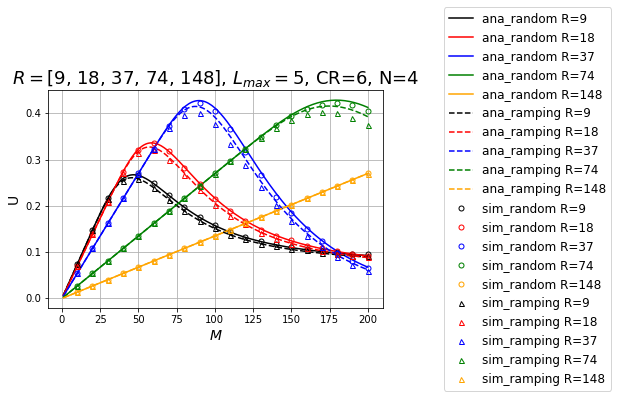

In [20]:
plt.plot(m_list, u_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, u_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, u_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, u_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, u_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, u_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, u_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, u_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, u_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, u_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, u_list_simu_9_random, label='sim_random R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.plot(m_list_simu, u_list_simu_9_ramp, label='sim_ramping R=9', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max}=$' + str(Lmax) + ', CR=6, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

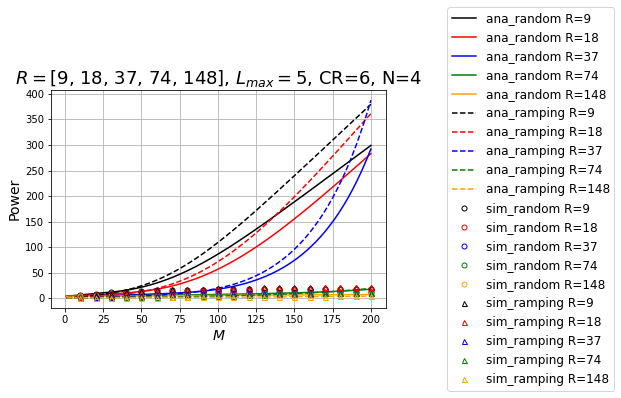

In [21]:
plt.plot(m_list, power_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, power_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, power_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, power_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, power_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, power_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, power_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, power_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, power_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, power_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, power_list_simu_9_random, label='sim_random R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, power_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, power_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, power_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, power_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.plot(m_list_simu, power_list_simu_9_ramp, label='sim_ramping R=9', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, power_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, power_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, power_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, power_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max}=$' + str(Lmax) + ', CR=6, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Power", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# CR=3

In [22]:
R = [9,18,37,74,148]
Lmax = 5
sta_max = 200
# sta_max = 500
m_list = [i for i in range(1, sta_max+1)]

ps_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_ramp  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

# Random
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_random(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=3, step=4)
        ps_list_random[idx][sta-1] = Ps
        da_list_random[idx][sta-1] = Da
        u_list_random[idx][sta-1] = U
        power_list_random[idx][sta-1] = power

# RampUp
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_rampup(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=3, step=4)
        ps_list_ramp[idx][sta-1] = Ps
        da_list_ramp[idx][sta-1] = Da
        u_list_ramp[idx][sta-1] = U
        power_list_ramp[idx][sta-1] = power

### random simu result

In [23]:
# Simulation r

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9_random = [1.0, 0.9992000000000003, 0.9868666666666664, 0.921100000000001, 0.7861599999999983, 0.6252000000000002, 0.48565714285714195, 0.3754499999999999, 0.2992555555555553, 0.24246999999999966, 0.19859090909090923, 0.16803333333333365, 0.143307692307693, 0.1260857142857144, 0.11149333333333382, 0.09946250000000002, 0.09002941176470612, 0.08245555555555562, 0.07583157894736821, 0.07055000000000007]
da_list_simu_9_random = [10.784373000000024, 17.63806529561412, 25.6030912318618, 32.34681481219985, 37.752948992648314, 41.989665250044126, 45.43022469644156, 48.61469746278638, 51.2876643439078, 53.9426705075223, 56.28370345297647, 58.38328997328168, 60.28627475476477, 61.760050202708456, 63.126469180566026, 64.49995273655517, 65.49606442948483, 66.26043895866985, 66.88655889808764, 67.53105687190096]
t_list_simu_9_random = [0.6666666666666636, 1.3322666666666607, 1.973733333333333, 2.4562666666666653, 2.620533333333329, 2.500800000000001, 2.2664000000000026, 2.0023999999999993, 1.7955333333333343, 1.616466666666668, 1.4563333333333355, 1.3442666666666692, 1.2420000000000033, 1.1768000000000012, 1.114933333333334, 1.0609333333333348, 1.0203333333333338, 0.9894666666666654, 0.9605333333333332, 0.9406666666666664]
u_list_simu_9_random = [0.074074074074075, 0.14802962962963145, 0.21930370370370653, 0.27291851851851834, 0.29117037037036997, 0.27786666666666643, 0.2518222222222227, 0.22248888888888899, 0.19950370370370396, 0.17960740740740683, 0.16181481481481477, 0.14936296296296295, 0.1380000000000001, 0.13075555555555574, 0.12388148148148174, 0.11788148148148164, 0.11337037037037055, 0.10994074074074087, 0.10672592592592592, 0.10451851851851868]
power_list_simu_9_random = [6.0235999999999965, 8.404516374268997, 10.973920353528973, 12.95900926860357, 14.327624394363491, 15.387232584903364, 16.026365811696003, 16.6654320508845, 17.00892118872878, 17.493143161568142, 17.727689763432554, 17.99587231647741, 18.269478143932748, 18.430037727432303, 18.472812770798345, 18.585286183015594, 18.763482189465236, 18.73605240736132, 18.91151950919814, 18.925321186692695]


ps_list_simu_18_random = [1.0, 1.0, 0.9995333333333334, 0.9943000000000024, 0.9627200000000073, 0.8684499999999992, 0.7305142857142857, 0.5809125000000007, 0.4525222222222221, 0.35513000000000006, 0.2849181818181817, 0.22958333333333322, 0.18796923076923078, 0.1574357142857139, 0.13554666666666668, 0.11608124999999991, 0.10342352941176516, 0.08973333333333335, 0.08141052631578925, 0.07371499999999993]
da_list_simu_18_random = [7.459995000000027, 9.959518800000048, 13.044685765763516, 16.76713475687369, 20.375270149097997, 23.603873454407527, 26.00610635993148, 27.91958054668412, 29.55356907377077, 31.195143353814814, 32.63750416982867, 33.96107131348016, 35.3860307287702, 36.45319012926977, 37.48104797647525, 38.63566398950692, 39.4560518456507, 40.24292611684574, 40.854261144575766, 41.45166720061202]
t_list_simu_18_random = [1.25, 2.5, 3.74825, 4.9715, 6.017, 6.513375, 6.392, 5.809125, 5.090875, 4.439125, 3.917625, 3.44375, 3.0545, 2.755125, 2.5415, 2.321625, 2.19775, 2.019, 1.9335, 1.842875]
u_list_simu_18_random = [0.06944444444444328, 0.13888888888888656, 0.20823611111111356, 0.27619444444444075, 0.33427777777777795, 0.36185416666666614, 0.35511111111111116, 0.3227291666666663, 0.28282638888888867, 0.24661805555555563, 0.21764583333333343, 0.1913194444444445, 0.16969444444444443, 0.15306250000000013, 0.14119444444444426, 0.12897916666666653, 0.12209722222222233, 0.11216666666666686, 0.10741666666666672, 0.10238194444444464]
power_list_simu_18_random = [4.919800000000001, 6.310800000000004, 7.979037110016413, 9.822122841928103, 11.577760699699372, 13.112454091582439, 14.146840847019668, 14.954787487237901, 15.519840093574947, 16.09853396223049, 16.533515484612458, 16.943849154261144, 17.369089558801104, 17.66224572784426, 17.8067727368299, 18.078355984583247, 18.262850888212437, 18.48408491195904, 18.45147792214715, 18.7277315150222]


ps_list_simu_37_random = [1.0, 1.0, 1.0, 1.0, 0.9999600000000001, 0.9993500000000003, 0.9964857142857126, 0.9814874999999983, 0.9382333333333326, 0.8472299999999987, 0.728290909090909, 0.5931750000000006, 0.4663384615384586, 0.3637999999999997, 0.27858666666666676, 0.21635000000000015, 0.165158823529412, 0.12532777777777768, 0.09738421052631555, 0.07541000000000006]
da_list_simu_37_random = [6.509200199999997, 7.432764600000034, 8.435372800000017, 9.576024000000066, 10.826642638775514, 12.188808393598118, 13.798060361879907, 15.407489027932671, 16.823302816077753, 17.831549184870312, 18.357311325119895, 18.625362298830133, 18.636296636827222, 18.5490982305578, 18.405913167165327, 18.239836000502642, 17.980296946245343, 17.852278429010333, 17.808686150732328, 17.606757400754805]
t_list_simu_37_random = [2.0, 4.0, 6.0, 8.0, 9.999600000000001, 11.9922, 13.9508, 15.703799999999973, 16.888199999999998, 16.944599999999987, 16.022400000000022, 14.236200000000007, 12.124799999999995, 10.186399999999995, 8.357599999999996, 6.923200000000005, 5.615399999999989, 4.511799999999995, 3.7005999999999997, 3.0163999999999973]
u_list_simu_37_random = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.270259459459455, 0.32411351351351214, 0.3770486486486511, 0.4244270270270284, 0.4564378378378369, 0.45796216216216196, 0.4330378378378372, 0.3847621621621616, 0.32769729729729735, 0.2753081081081083, 0.2258810810810807, 0.1871135135135136, 0.15176756756756773, 0.12194054054054063, 0.10001621621621598, 0.08152432432432422]
power_list_simu_37_random = [4.333600000000003, 4.923749999999997, 5.5754666666666655, 6.324625000000006, 7.154436326530605, 8.05647571712075, 9.159895108928643, 10.21524656023526, 11.216962424844485, 11.934768657330268, 12.387799645374361, 12.626924506466233, 12.662419054065163, 12.664229587725918, 12.631914629438583, 12.55231105419205, 12.374178484938556, 12.338845428883918, 12.329741724866215, 12.162090917827975]


ps_list_simu_74_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99999, 0.9998545454545456, 0.9997333333333336, 0.9988692307692305, 0.9969571428571399, 0.9922533333333384, 0.9816937499999988, 0.96485294117648, 0.9374499999999988, 0.8968842105263182, 0.8499050000000028]
da_list_simu_74_random = [6.085994399999954, 6.536714250000021, 7.008613299999989, 7.4504927250000375, 7.967501579999989, 8.479622200000012, 9.014883257142852, 9.569854612500084, 10.190031699999997, 10.843490817272729, 11.48693908432601, 12.288188029717976, 13.020994956087803, 13.821204473351413, 14.639558804522826, 15.442101371037607, 16.19312200375222, 16.816726737065864, 17.368300043571292, 17.829880049044572]
t_list_simu_74_random = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 19.9998, 21.996799999999997, 23.993599999999986, 25.97059999999997, 27.914799999999914, 29.767599999999884, 31.414199999999962, 32.805, 33.74819999999997, 34.081600000000016, 33.99620000000002]
u_list_simu_74_random = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621621621621823, 0.24324324324324892, 0.2702675675675631, 0.29725405405404937, 0.32423783783783655, 0.35095405405405666, 0.37722702702702854, 0.40226486486486757, 0.42451621621621705, 0.4433108108108104, 0.4560567567567566, 0.46056216216216195, 0.4594081081081085]
power_list_simu_74_random = [4.008900000000004, 4.334049999999997, 4.637899999999992, 4.91615, 5.275399999999996, 5.607883333333334, 5.97915714285713, 6.332924999999991, 6.745633333333331, 7.185263333333325, 7.578045067324191, 8.11031249109813, 8.6139711836581, 9.129424590631665, 9.686795496269559, 10.228551650540915, 10.743763963957079, 11.174746436014726, 11.596519838035231, 11.932338512198832]


ps_list_simu_148_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999882352941176, 1.0, 0.9999789473684211, 0.999985]
da_list_simu_148_random = [5.885170199999907, 6.13364759999999, 6.31669639999999, 6.572170500000028, 6.794098260000024, 7.032818100000005, 7.278458999999985, 7.499138700000041, 7.747174866666687, 7.994845439999991, 8.248335709090902, 8.518245874999998, 8.759330192307676, 9.06091559999998, 9.302282840000002, 9.62931474375005, 9.9232648340336, 10.241435383333343, 10.555653585386336, 10.851627270226158]
t_list_simu_148_random = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 33.9996, 36.0, 37.999199999999995, 39.999399999999994]
u_list_simu_148_random = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2027027027027067, 0.21621621621621823, 0.22972702702703035, 0.24324324324324892, 0.25675135135134536, 0.27026621621621183]
power_list_simu_148_random = [3.9142000000000037, 4.0381999999999945, 4.156766666666666, 4.342575, 4.494339999999998, 4.64586666666667, 4.807514285714288, 4.955312500000001, 5.124955555555559, 5.276459999999998, 5.4467363636363615, 5.640133333333331, 5.774769230769226, 5.994714285714291, 6.153873333333339, 6.363699999999997, 6.5560521008403345, 6.7576611111111085, 6.988809854423299, 7.173932883863768]

### Ramp Up simu result

In [24]:
# Rampup

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9_ramp = [1.0, 0.9993500000000003, 0.9839333333333332, 0.9102750000000015, 0.7682200000000007, 0.6078500000000001, 0.46961428571428554, 0.36164999999999997, 0.28467777777777786, 0.2324499999999997, 0.1908818181818184, 0.16269166666666718, 0.13787692307692362, 0.12077142857142847, 0.10812666666666698, 0.09721249999999994, 0.08638235294117688, 0.08090000000000022, 0.07488421052631565, 0.06785500000000008]
da_list_simu_9_ramp = [10.849045200000038, 18.18842094035101, 26.042219966326815, 32.88848261869137, 38.209769012575016, 42.28968054811987, 45.59094121369064, 48.780174473699965, 51.6741287773368, 54.06379354322196, 56.61161527187431, 58.597509869844544, 60.39590147059398, 62.07558254514441, 63.45475456964006, 64.56465090436929, 65.54778908286937, 66.17891025784253, 66.97519408396954, 67.64597856932919]
t_list_simu_9_ramp = [0.6666666666666636, 1.332466666666661, 1.9678666666666664, 2.427400000000005, 2.5607333333333337, 2.4314000000000004, 2.191533333333338, 1.9287999999999994, 1.708066666666667, 1.5496666666666654, 1.3998000000000026, 1.3015333333333374, 1.1949333333333363, 1.1272, 1.0812666666666675, 1.0369333333333348, 0.9789999999999994, 0.9708000000000007, 0.9485333333333338, 0.9047333333333317]
u_list_simu_9_ramp = [0.074074074074075, 0.14805185185185366, 0.2186518518518544, 0.2697111111111111, 0.28452592592592524, 0.2701555555555555, 0.24350370370370403, 0.21431111111111145, 0.18978518518518508, 0.17218518518518505, 0.15553333333333316, 0.14461481481481475, 0.13277037037037048, 0.12524444444444474, 0.12014074074074087, 0.11521481481481503, 0.10877777777777795, 0.10786666666666656, 0.10539259259259254, 0.10052592592592602]
power_list_simu_9_ramp = [2.426199999999997, 4.975796491228061, 8.39842023139834, 11.68847045971796, 14.140563265725834, 15.789688075950513, 16.99115355415785, 18.10035395966342, 18.915671863603343, 19.629142912381393, 20.285710342310857, 20.79165211148157, 21.24198991479423, 21.60103350013041, 21.94694427072996, 22.13169043438645, 22.32148298069473, 22.405601925872155, 22.511731189096302, 22.655686084984872]


ps_list_simu_18_ramp = [1.0, 1.0, 0.9994333333333333, 0.991475000000003, 0.9479200000000059, 0.8430833333333316, 0.7020428571428574, 0.5538625000000004, 0.4307888888888886, 0.3372400000000003, 0.27019090909090904, 0.2179916666666664, 0.18287692307692327, 0.15154285714285687, 0.13003333333333364, 0.11281875000000009, 0.09880000000000033, 0.08727777777777754, 0.07893684210526285, 0.07176500000000002]
da_list_simu_18_ramp = [7.516157700000022, 10.17367455000005, 13.41519228349754, 17.122269618911556, 20.790935664498104, 23.920003660383582, 26.265858353667134, 28.12017444893618, 29.771333464399564, 31.247846646037527, 32.71863997251487, 34.09810873538073, 35.38860282413716, 36.529785820401806, 37.639179218433306, 38.5939146878164, 39.65044624191721, 40.23893897227945, 40.90722730384092, 41.550028114003496]
t_list_simu_18_ramp = [1.25, 2.5, 3.747875, 4.957375, 5.9245, 6.323125, 6.142875, 5.538625, 4.846375, 4.2155, 3.715125, 3.269875, 2.97175, 2.652, 2.438125, 2.256375, 2.0995, 1.96375, 1.87475, 1.794125]
u_list_simu_18_ramp = [0.06944444444444328, 0.13888888888888656, 0.20821527777778023, 0.2754097222222192, 0.32913888888888954, 0.3512847222222224, 0.34127083333333313, 0.30770138888888887, 0.2692430555555555, 0.23419444444444426, 0.20639583333333303, 0.18165972222222213, 0.16509722222222203, 0.14733333333333323, 0.13545138888888866, 0.1253541666666669, 0.11663888888888899, 0.10909722222222235, 0.10415277777777808, 0.09967361111111112]
power_list_simu_18_ramp = [1.6858000000000035, 2.865699999999998, 4.674277668308704, 7.173459526414791, 9.931853058294834, 12.275517501603868, 13.993924369869218, 15.203354353066462, 16.251671283403855, 17.059124604900926, 17.95994829811132, 18.674310414892656, 19.350265820733693, 19.904767899385202, 20.454900284526143, 20.917142864840283, 21.39487580246768, 21.620759411361643, 21.916177239802533, 22.142598580655932]


ps_list_simu_37_ramp = [1.0, 1.0, 1.0, 0.99995, 0.9999000000000001, 0.9988166666666668, 0.9929142857142841, 0.9680875000000004, 0.9050000000000004, 0.8074200000000004, 0.6793636363636355, 0.5536083333333335, 0.4369076923076884, 0.33676428571428535, 0.26039999999999996, 0.2003437500000003, 0.1541529411764708, 0.11791666666666677, 0.09010526315789454, 0.07004500000000004]
da_list_simu_37_ramp = [6.590324100000012, 7.517575950000044, 8.585707300000008, 9.740414103947426, 11.055066852091823, 12.574848509036794, 14.154656414195234, 15.72075828378089, 16.964224635960978, 17.865781815582302, 18.311349679840678, 18.47002475695625, 18.550600510835594, 18.422417307988393, 18.222682742864276, 18.071227577823876, 17.918082740771666, 17.840064793954152, 17.750308260370492, 17.592093591495125]
t_list_simu_37_ramp = [2.0, 4.0, 6.0, 7.9996, 9.999, 11.985800000000006, 13.90080000000002, 15.489400000000007, 16.289999999999996, 16.1484, 14.945999999999989, 13.286600000000007, 11.359599999999997, 9.429399999999994, 7.812000000000005, 6.411000000000009, 5.241200000000003, 4.245000000000003, 3.4239999999999973, 2.8018000000000023]
u_list_simu_37_ramp = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21620540540540742, 0.27024324324323884, 0.3239405405405391, 0.37569729729729967, 0.4186324324324336, 0.4402702702702698, 0.43644324324324263, 0.40394594594594585, 0.3590972972972965, 0.3070162162162159, 0.2548486486486486, 0.21113513513513513, 0.17327027027027028, 0.1416540540540537, 0.11472972972972965, 0.09254054054054041, 0.07572432432432424]
power_list_simu_37_ramp = [1.335000000000007, 1.726000000000001, 2.2434000000000025, 2.9212552631578945, 3.850231666666666, 5.113033904580218, 6.597734006454056, 8.217575140026396, 9.563061677484113, 10.551178819615227, 11.068076112162387, 11.249169328259885, 11.344993227689292, 11.221627153965569, 11.020805921390886, 10.878160394215291, 10.704090273630447, 10.61968441792842, 10.529037540488131, 10.357209889327144]


ps_list_simu_74_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998100000000002, 0.9997363636363639, 0.999091666666667, 0.9971769230769224, 0.9928214285714239, 0.9838666666666748, 0.9671812500000005, 0.9439352941176506, 0.9067388888888871, 0.8612842105263149, 0.8058949999999993]
da_list_simu_74_ramp = [6.106417199999959, 6.58635300000002, 7.0608049, 7.55728695000003, 8.069048279999988, 8.629200300000004, 9.193582757142847, 9.753517987500086, 10.38575019999998, 11.110242668194173, 11.856149663872674, 12.569929996842578, 13.407453856952113, 14.187832670403816, 15.023550230015077, 15.7830702774414, 16.43889246533104, 16.995436967064077, 17.47427597690943, 17.836741458967808]
t_list_simu_74_ramp = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 19.996199999999998, 21.9942, 23.97819999999999, 25.92659999999995, 27.798999999999886, 29.515999999999877, 30.949800000000018, 32.093800000000016, 32.6426, 32.7288, 32.2358]
u_list_simu_74_ramp = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621621621621823, 0.24324324324324892, 0.27021891891891453, 0.2972189189189143, 0.3240297297297284, 0.3503594594594624, 0.3756621621621622, 0.3988648648648649, 0.4182405405405407, 0.43369999999999903, 0.44111621621621616, 0.44228108108108055, 0.4356189189189185]
power_list_simu_74_ramp = [1.1548000000000054, 1.3312999999999995, 1.5187333333333342, 1.7320500000000003, 1.9750399999999995, 2.260100000000002, 2.578657142857145, 2.924700000000002, 3.344000000000001, 3.886866575963719, 4.488595731010409, 5.10977225998524, 5.888077001881073, 6.645195385699066, 7.495837106213239, 8.286204747898212, 8.984218532670685, 9.584241883760454, 10.119171278492168, 10.526990171289532]


ps_list_simu_148_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999888888888888, 0.9999631578947369, 0.9999250000000001]
da_list_simu_148_ramp = [5.883468299999908, 6.139887899999993, 6.379477600000005, 6.630035100000014, 6.836986140000012, 7.1196149999999925, 7.342725985714284, 7.590332175000038, 7.842229133333346, 8.090435489999996, 8.346942763636354, 8.614166850000002, 8.914028538461524, 9.221623585714278, 9.502653200000001, 9.808156068750055, 10.132445188235323, 10.47264058764045, 10.763753735523203, 11.126720924278976]
t_list_simu_148_ramp = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 35.9996, 37.99859999999999, 39.99699999999999]
u_list_simu_148_ramp = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2027027027027067, 0.21621621621621823, 0.22972972972973307, 0.24324054054054622, 0.2567472972972913, 0.2702499999999956]
power_list_simu_148_ramp = [1.0742000000000027, 1.1658000000000022, 1.2538666666666722, 1.3481500000000006, 1.4296000000000002, 1.5431000000000001, 1.6375428571428536, 1.7450999999999985, 1.8636222222222225, 1.9785800000000018, 2.108781818181817, 2.2470166666666644, 2.411661538461543, 2.5886857142857114, 2.7600399999999983, 2.9548375000000013, 3.1739999999999977, 3.4098781523096107, 3.6219440818357946, 3.8965143601847654]


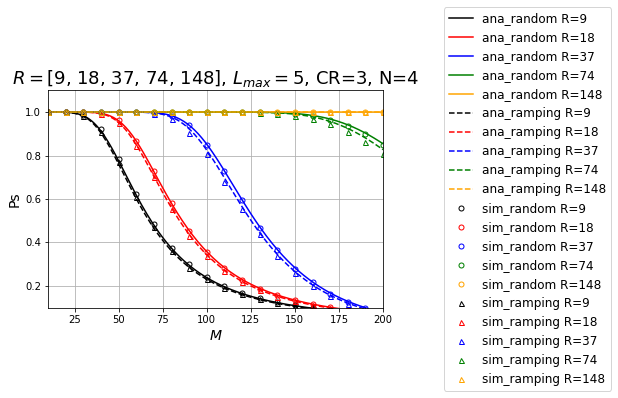

In [25]:
plt.plot(m_list, ps_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, ps_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, ps_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, ps_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, ps_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, ps_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, ps_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, ps_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, ps_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, ps_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, ps_list_simu_9_random, label='sim_random R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.plot(m_list_simu, ps_list_simu_9_ramp, label='sim_ramping R=9', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR=3, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

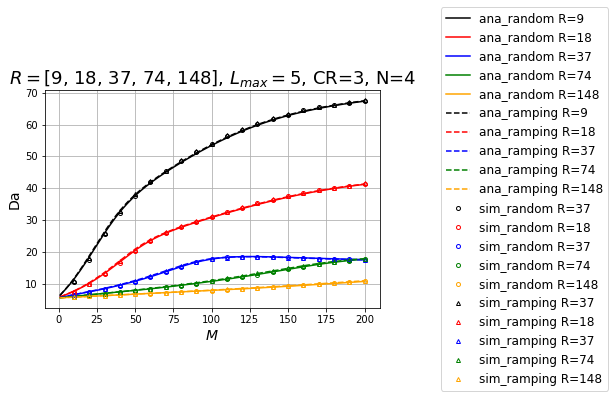

In [26]:
plt.plot(m_list, da_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, da_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, da_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, da_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, da_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, da_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, da_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, da_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, da_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, da_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, da_list_simu_9_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.plot(m_list_simu, da_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.plot(m_list_simu, da_list_simu_9_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.plot(m_list_simu, da_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=4)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR=3, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

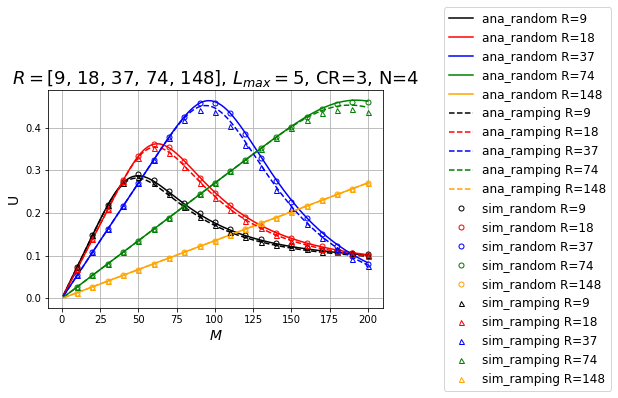

In [27]:
plt.plot(m_list, u_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, u_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, u_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, u_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, u_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, u_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, u_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, u_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, u_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, u_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, u_list_simu_9_random, label='sim_random R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.plot(m_list_simu, u_list_simu_9_ramp, label='sim_ramping R=9', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR=3, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

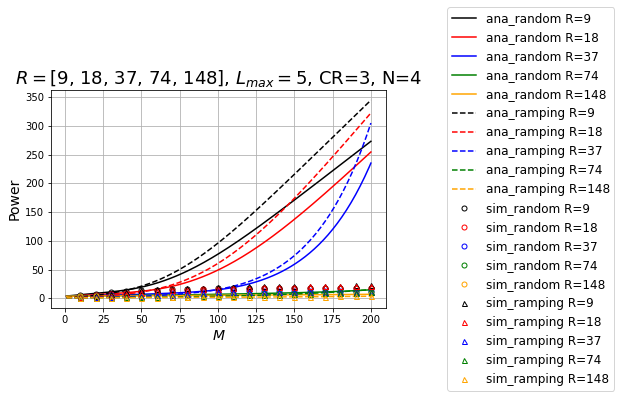

In [28]:
plt.plot(m_list, power_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, power_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, power_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, power_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, power_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, power_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, power_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, power_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, power_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, power_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, power_list_simu_9_random, label='sim_random R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, power_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, power_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, power_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, power_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.plot(m_list_simu, power_list_simu_9_ramp, label='sim_ramping R=9', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, power_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, power_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, power_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, power_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max}=$' + str(Lmax) + ', CR=3, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Power", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()